<a href="https://colab.research.google.com/github/ishammansoor/AI-and-Machine-Learning/blob/main/ML_Optimization_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing required libraries for the machine learning model

In [1]:
!pip install time
!pip install tensorflow-model-optimization

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import tf_keras as keras

import time
import numpy as np

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.3 MB/s eta 0:00:00


### Loading Dataset

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

print(x_train.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
(50000, 32, 32, 3)


### Visualization of the dataset and creating the model






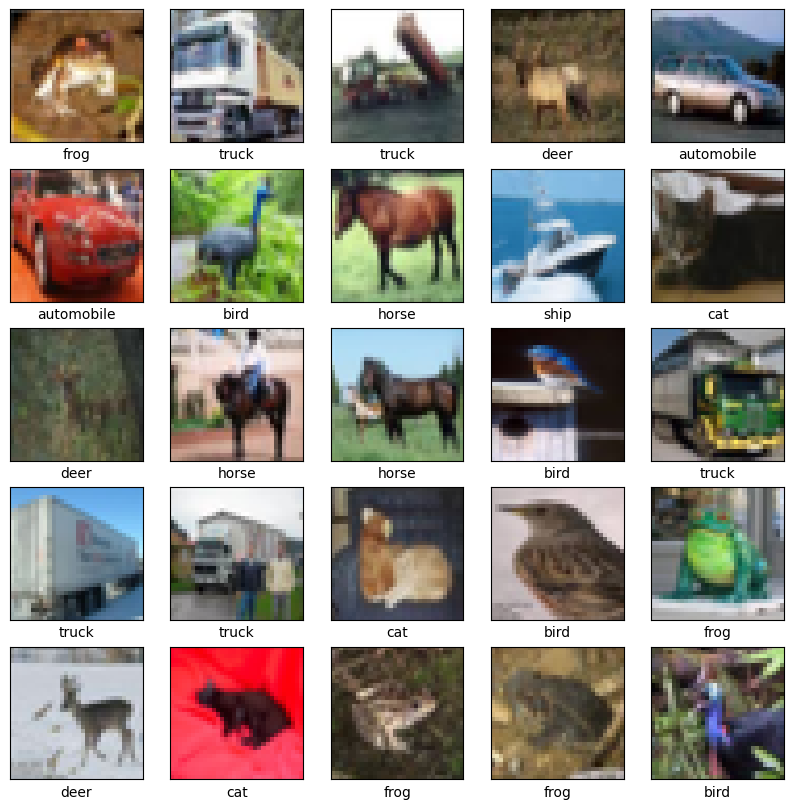

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

Lets create a Standard convolutional neural network

In [4]:
#creating a sequential neural network

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)
])

model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

Training the model using

In [ ]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
)

Epoch 1/10
1563/1563 [==============================] - 82s 50ms/step - loss: 1.5101 - accuracy: 0.4522
Epoch 2/10
1563/1563 [==============================] - 71s 45ms/step - loss: 1.1714 - accuracy: 0.5844
Epoch 3/10
1563/1563 [==============================] - 70s 45ms/step - loss: 1.0123 - accuracy: 0.6434
Epoch 4/10
1563/1563 [==============================] - 68s 43ms/step - loss: 0.9014 - accuracy: 0.6824
Epoch 5/10
1563/1563 [==============================] - 67s 43ms/step - loss: 0.8286 - accuracy: 0.7089
Epoch 6/10
 423/1563 [=======>......................] - ETA: 59s - loss: 0.7523 - accuracy: 0.7329

Plotting the history of the accuracy of the model

313/313 - 7s - loss: 0.8917 - accuracy: 0.7093 - 7s/epoch - 21ms/step


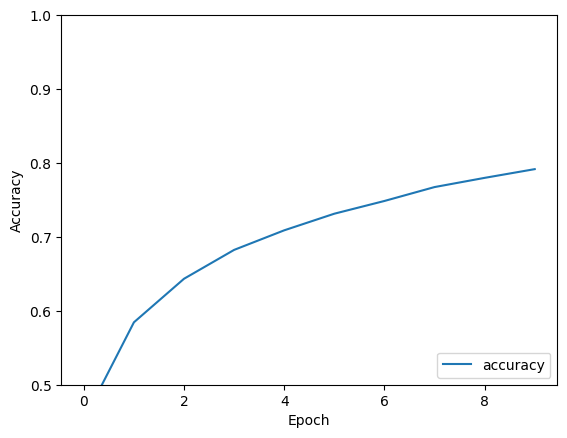

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

### Lets see the cpu usage for the standard model
Lets see the energy consumption for the standard Convolutional neural network


In [65]:
import threading
import psutil


# Function to record CPU usage
def monitor_cpu_usage(duration, interval=0.5):
    cpu_usage = []
    start_time = time.time()
    while time.time() - start_time < duration:
        cpu_usage.append(psutil.cpu_percent(interval=interval))
    return cpu_usage

# Function to monitor CPU asynchronously
def async_monitor_cpu(cpu_time, cpu_usage_list, stop_event, interval=0.5):
    while not stop_event.is_set():
        cpu_usage_list.append(psutil.cpu_percent(interval=interval))
        cpu_time.append(time.time())

# Measure baseline CPU usage
baseline_cpu_usage = monitor_cpu_usage(duration=5, interval=0.5)

# Start monitoring CPU during `.fit()`
cpu_usage = []
cpu_time = []
stop_event = threading.Event()
monitor_thread = threading.Thread(target=async_monitor_cpu, args=(cpu_time, cpu_usage, stop_event))

monitor_thread.start()

# Run the `.fit()` command
# for i in range(4):
model.predict(x_train)

# Stop monitoring
stop_event.set()
monitor_thread.join()

1563/1563 [==============================] - 25s 16ms/step


Baseline CPU Usage: 8.70%
CPU Usage During `.fit()`: 94.30%


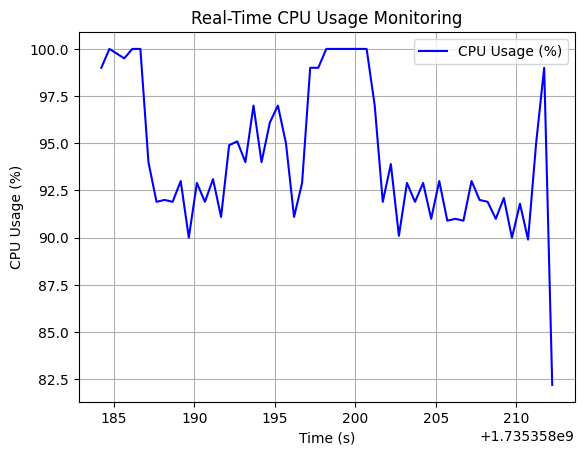

In [66]:
plt.plot(cpu_time, cpu_usage, label="CPU Usage (%)", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("CPU Usage (%)")
plt.title("Real-Time CPU Usage Monitoring")
plt.legend(loc="upper right")
plt.grid(True)

# baseline
baseline_avg = np.mean(baseline_cpu_usage)
print(f"Baseline CPU Usage: {baseline_avg:.2f}%")

# Analyze CPU usage during training
fit_avg_cpu_usage = np.mean(cpu_usage)
print(f"CPU Usage During `.fit()`: {fit_avg_cpu_usage:.2f}%")

### Lets move on to creating a pruning CNN model

In [39]:
!pip install tensorflow-model-optimization
import tempfile

_, baseline_model_accuracy = model.evaluate(
    x_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.7092999815940857
Saved baseline model to: /tmp/tmpth0kzmih.h5


<ipython-input-39-3fc564c7e774>:10: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, keras_file, include_optimizer=False)


In [42]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 30, 30, 32)        1762      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_max_po  (None, 15, 15, 32)        1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 13, 13, 64)        36930     
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 6, 6, 64)          1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                                                    

In [45]:
logdir = tempfile.mkdtemp()
#needed for fitting
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(x_train, y_train, epochs=10, callbacks=callbacks)

Epoch 1/10
1563/1563 [==============================] - 74s 47ms/step - loss: 0.8554 - accuracy: 0.6984
Epoch 2/10
1563/1563 [==============================] - 77s 49ms/step - loss: 0.6595 - accuracy: 0.7670
Epoch 3/10
1563/1563 [==============================] - 73s 47ms/step - loss: 0.6037 - accuracy: 0.7874
Epoch 4/10
1563/1563 [==============================] - 72s 46ms/step - loss: 0.5694 - accuracy: 0.7968
Epoch 5/10
1563/1563 [==============================] - 71s 46ms/step - loss: 0.5435 - accuracy: 0.8077
Epoch 6/10
1563/1563 [==============================] - 72s 46ms/step - loss: 0.5207 - accuracy: 0.8148
Epoch 7/10
1563/1563 [==============================] - 74s 48ms/step - loss: 0.5028 - accuracy: 0.8218
Epoch 8/10
1563/1563 [==============================] - 73s 47ms/step - loss: 0.4893 - accuracy: 0.8266
Epoch 9/10
1563/1563 [==============================] - 72s 46ms/step - loss: 0.4746 - accuracy: 0.8334
Epoch 10/10
1563/1563 [==============================] - 83s 53m

In [46]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   x_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.7092999815940857
Pruned test accuracy: 0.7153000235557556


In [67]:
# Measure baseline CPU usage
baseline_cpu_usage = monitor_cpu_usage(duration=5, interval=0.5)

# Start monitoring CPU during `.fit()`
cpu_usage = []
cpu_time = []
stop_event = threading.Event()
monitor_thread = threading.Thread(target=async_monitor_cpu, args=(cpu_time, cpu_usage, stop_event))

monitor_thread.start()

# Run the `.fit()` command
model_for_pruning.predict(x_train)

# Stop monitoring
stop_event.set()
monitor_thread.join()

1563/1563 [==============================] - 25s 16ms/step


Baseline CPU Usage: 88.68%
CPU Usage During `.fit()`: 88.68%


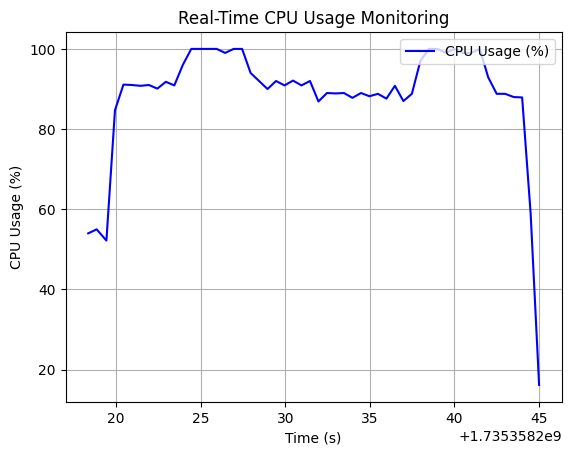

In [68]:
plt.plot(cpu_time, cpu_usage, label="CPU Usage (%)", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("CPU Usage (%)")
plt.title("Real-Time CPU Usage Monitoring")
plt.legend(loc="upper right")
plt.grid(True)

# baseline
baseline_avg = np.mean(cpu_usage)
print(f"Baseline CPU Usage: {baseline_avg:.2f}%")

# Analyze CPU usage during training
fit_avg_cpu_usage = np.mean(cpu_usage)
print(f"CPU Usage During `.fit()`: {fit_avg_cpu_usage:.2f}%")